For the histroical period, how similar are the models to one another and the observations?

In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np 
import xarray as xr
from ensembles.plotters import _unique_legend
from ensembles.wasserstein import gaussian_w2_distance_distrax

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
# sns.set_style('whitegrid')
# sns.set() # To keep x and y ticks

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-07-15 16:13:20.401661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Load in data (historical model and observations)

In [2]:
obs_da = xr.open_dataarray('data/obs/gmst/HadCRUT.5.0.1.0.analysis.anomalies_gmst.nc')
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')

hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*nc')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[:2])
    hist_model_files[model_name] = model_file

# Load historical modes and calculate the anomally, and climatology (for the forecast models)
hist_anom_models = []
climatology_dict = dict()
for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    da = xr.open_dataarray(mf)
    # Use observational time for ease of comparison between models and obs
    da['time'] = obs_time
    # Put data into a ProcessModel class
    model_data = es.ProcessModel(da, mn)
    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

hist_anom_models = es.ModelCollection(hist_anom_models)

In [3]:
hist_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=2000)
dist = es.GPDTW1D().fit(observations, compile_objective=True, n_optim_nits=2000)
observations.distribution = dist


/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "
2022-07-15 16:13:27.908416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-15 16:13:27.908452: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-15 16:13:28.305901: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|██████████| 2000/2000 [01:55<00:00, 17.34it/s, loss=-333.65]


Calculating the Wasserstein distance (W2) for all model-model and all model-observations pairs

In [4]:
w2_dists = np.zeros(shape=(hist_anom_models.number_of_models + 2, hist_anom_models.number_of_models + 2)) * np.nan
for i in range(hist_anom_models.number_of_models):
    for j in range(hist_anom_models.number_of_models):
        w2_model = gaussian_w2_distance_distrax(
            hist_anom_models[i].distribution._dist,
            hist_anom_models[j].distribution._dist,
            full_cov=True)
        w2_dists[i, j] = w2_model
    w2_obs = gaussian_w2_distance_distrax(
                hist_anom_models[i].distribution._dist,
                observations.distribution._dist,
                full_cov=True)
    w2_dists[i, -1] = w2_obs
    w2_dists[-1, i] = w2_obs
    w2_dists[-1, -1] = gaussian_w2_distance_distrax(
                            observations.distribution._dist,
                            observations.distribution._dist,
                            full_cov=True)

In [5]:
labels = [m.split(' ')[0].split('_')[1] for m in hist_anom_models.model_names] + [None] + ['Observations']

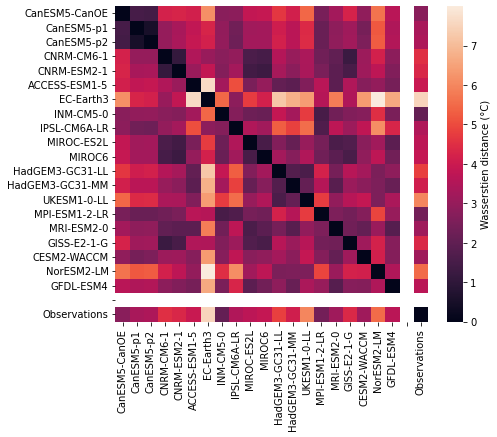

In [9]:
plt.figure(figsize=(7, 5.8))
sns.heatmap(np.asarray(w2_dists), xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Wasserstien distance (°C)'})

plt.savefig('figures/hist_model_posterior_similarity.png', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('figures/hist_model_posterior_similarity.pdf', bbox_inches='tight', transparent=True)


plt.show()
